# Gender prediction based on first name using character sequences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

The dataset consist of french names.Most of the french names has tilde characters in their names.Below Function removes tilde characters from names and replaces them with normal characters

In [2]:
def rmv_acc(string_1):

    string_1 = string_1.replace("ç", "c")
    string_1 = string_1.replace("Ç", "C")
    string_1 = string_1.replace("à", "a")
    string_1 = string_1.replace("Ä", "A")
    string_1 = string_1.replace("ä", "a")
    string_1 = string_1.replace("À", "A")
    string_1 = string_1.replace("Â", "A")
    string_1 = string_1.replace("â", "a")
    string_1 = string_1.replace("é", "e")
    string_1 = string_1.replace("è", "e")
    string_1 = string_1.replace("É", "E")
    string_1 = string_1.replace("È", "E")
    string_1 = string_1.replace("Ë", "E")
    string_1 = string_1.replace("ë", "e")
    string_1 = string_1.replace("Ê", "E")
    string_1 = string_1.replace("ê", "e")
    string_1 = string_1.replace("û", "u")
    string_1 = string_1.replace("Û", "U")
    string_1 = string_1.replace("ü", "u")
    string_1 = string_1.replace("Ü", "U")
    string_1 = string_1.replace("ï", "i")
    string_1 = string_1.replace("Ï", "I")
    string_1 = string_1.replace("î", "i")
    string_1 = string_1.replace("Î", "I")
    string_1 = string_1.replace("Ô", "O")
    string_1 = string_1.replace("ô", "o")
    string_1 = string_1.replace("Ö", "O")
    string_1 = string_1.replace("ö", "o")
    string_1 = string_1.replace("Ù", "U")
    string_1 = string_1.replace("ù", "u")
    string_1 = string_1.replace("ÿ", "y")
    string_1 = string_1.replace("æ", "ae")
    string_1 = string_1.replace("_", " ")

    return string_1

In [3]:
df = pd.read_csv('nat2020.csv', sep=";")
df = df[['sexe', 'preusuel']].drop_duplicates()
df.columns = ['gender', 'name']

def sexe(x):
    if x == 1:
        return "M"
    else:
        return "F"
    
df['gender'] = df['gender'].apply(lambda x: sexe(x)) 
columnsTitles=["name","gender"]
df=df.reindex(columns=columnsTitles)

df2 = pd.read_csv('name_gender.csv')[['name', 'gender']]

df = pd.concat([df, df2])
df['name'] = df['name'].apply(lambda x: str(x).lower())
df['name'] = df['name'].apply(lambda x: rmv_acc(x))
df = df[[len(e)>1 for e in df.name]]
df = df.drop_duplicates()

names = df['name'].apply(lambda x: x.lower())
gender = df['gender']

df.head()

,name,gender
0,prenoms rares,M
124,aadam,M
131,aadel,M
139,aadil,M
165,aahil,M


checking the length of name's characters.

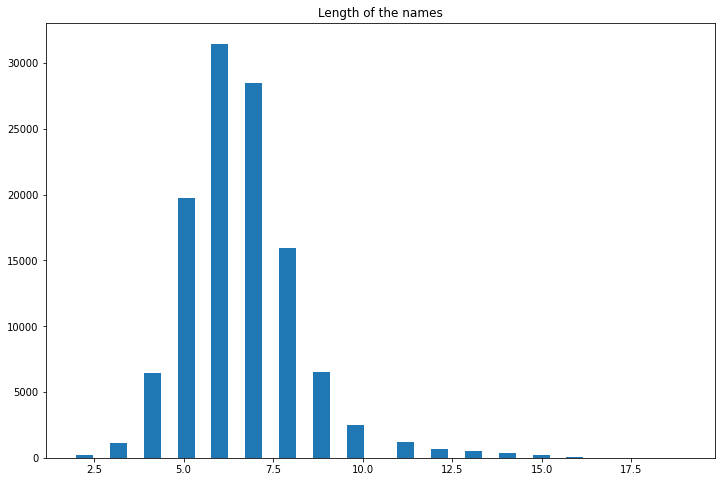

In [4]:
plt.figure(figsize=(12,8))
plt.hist([len(a) for a in names], bins=36)
plt.title("Length of the names")
plt.show()

In [5]:
maxlen = 20
labels = 2

In [6]:
print("Male : " + str(sum(gender=='M')))
print("Female : " + str(sum(gender=='F')))

Male : 44999
Female : 70528


In [7]:
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)
print(len_vocab)

30


In [8]:
char_index = dict((c, i) for i, c in enumerate(vocab))
char_index

{' ': 22,
 "'": 21,
 '-': 2,
 'END': 3,
 'a': 13,
 'b': 4,
 'c': 26,
 'd': 0,
 'e': 14,
 'f': 6,
 'g': 9,
 'h': 11,
 'i': 8,
 'j': 17,
 'k': 27,
 'l': 12,
 'm': 7,
 'n': 19,
 'o': 25,
 'p': 29,
 'q': 20,
 'r': 5,
 's': 16,
 't': 10,
 'u': 18,
 'v': 15,
 'w': 23,
 'x': 28,
 'y': 24,
 'z': 1}

Preprocessing the dataset for model training


In [9]:
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


X = prepare_X(names.values)

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

y = prepare_y(gender)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


Defining the deep model using lstm to find the sequences of character's names

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(512, return_sequences=True), backward_layer=LSTM(512, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(2, activity_regularizer=l2(0.002)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

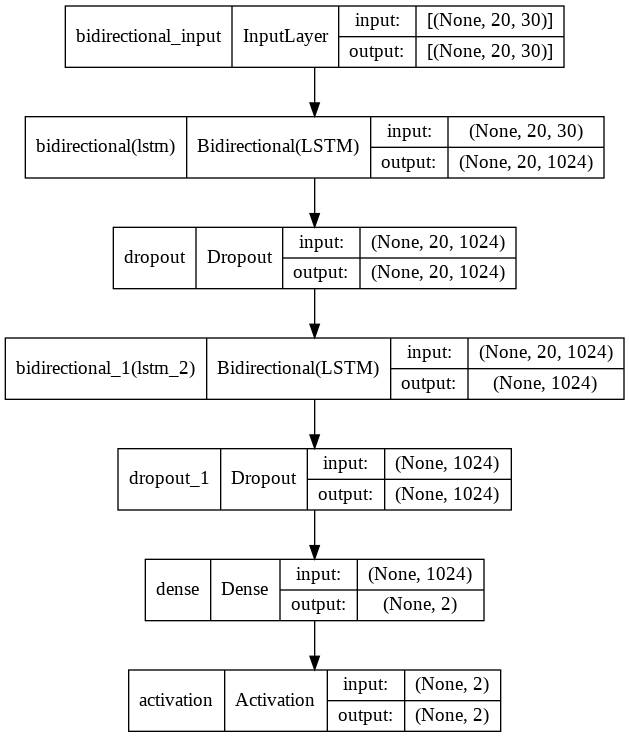

In [12]:
plot_model(model, to_file='model_2.png', show_shapes=True, expand_nested=True)

In [13]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model_9.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [14]:
batch_size = 256
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=35, verbose=1, validation_data =(X_test, y_test), callbacks=[callback, mc, reduce_lr_acc])

Epoch 1/35
339/339 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.7750
Epoch 00001: saving model to best_model_9.h5
339/339 [==============================] - 163s 448ms/step - loss: 0.4735 - accuracy: 0.7750 - val_loss: 0.4040 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 2/35
339/339 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8218
Epoch 00002: saving model to best_model_9.h5
339/339 [==============================] - 63s 186ms/step - loss: 0.3996 - accuracy: 0.8218 - val_loss: 0.3826 - val_accuracy: 0.8311 - lr: 0.0010
Epoch 3/35
339/339 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8346
Epoch 00003: saving model to best_model_9.h5
339/339 [==============================] - 64s 188ms/step - loss: 0.3758 - accuracy: 0.8346 - val_loss: 0.3605 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 4/35
339/339 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8457
Epoch 00004: saving model to best_model

Model's validation accuracy reached to its maximum so we saved this model and used this model to predict gender of the given names.

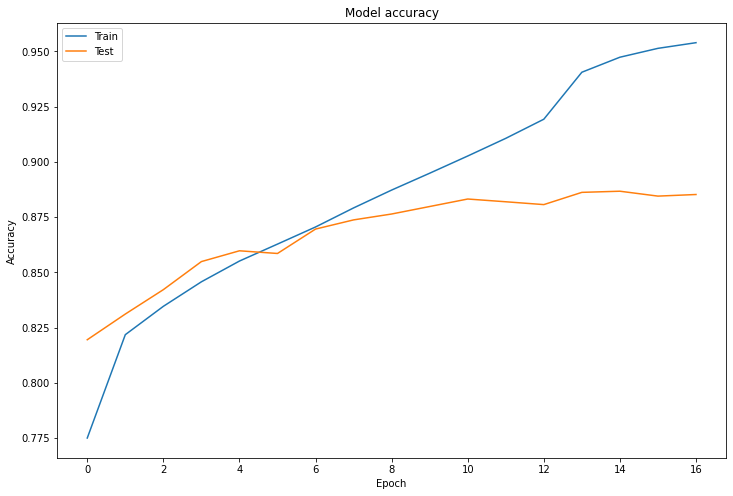

In [15]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
new_names = ["aadhya", "jenny", "alex","sujith"]
X_pred = prepare_X([rmv_acc(e) for e in new_names])

In [21]:
prediction = model.predict(X_pred)
prediction

array([[0.02658985, 0.9734101 ],
       [0.11986341, 0.88013655],
       [0.7397752 , 0.26022482],
       [0.99566513, 0.00433493]], dtype=float32)

In [22]:
def pred(new_names, prediction):
    dict_answer={}
    return_results = []
    k = 0
    for i in prediction:
        if max(i) < 0.65:
            return_results.append([new_names[k], "N"])
        else:
            return_results.append([new_names[k], np.argmax(i)])
        k += 1
    return return_results

Here, '0' means male name and '1' means female name.

In [23]:

pred(new_names, prediction)

[['aadhya', 1], ['jenny', 1], ['alex', 0], ['sujith', 0]]

Therefore, the model is predicting gender most accurately.